# Supervised Learning Final Project

by Zhen Lian

## Overview

The goal of this project is to develop a classifier that identify credit card fraud based on user transaction data. The dataset used in this project can be downloaded from Kaggle website (https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud). Link to GitHub repository: https://github.com/zlianrpi/credit-card-fraud-detection.git.

## Exploratory data analysis 

First we need to load the transaction data into a pandas dataframe and explore some basic information about the dataset.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, statsmodels.api as sm, statsmodels.formula.api as smf, seaborn as sns

In [2]:
df0 = pd.read_csv('card_transdata.csv')
df0

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


From the above information we know that the dataset contains 8 features and has 1000000 entries. None of the columns or rows contain null values so we don't need to drop any data points. Then let us check the distribution of the predictor variables and plot a boxplot of the numeric predictors.     

In [4]:
df0.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


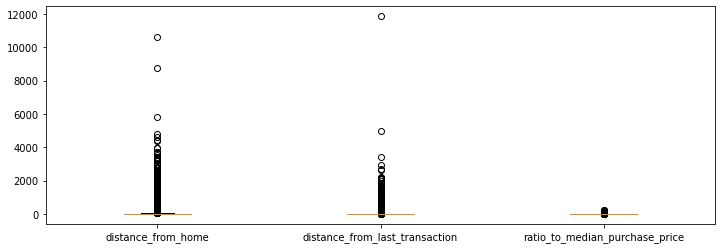

In [6]:
fig, ax = plt.subplots(1, 1, figsize=[12, 4])
plt.boxplot(df0[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])
plt.xticks([1, 2, 3], ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'])
plt.show()

From the statistic and the boxplot we can see the numerical predictors have very skewed distributions and have extreme outliers. So we might need to normalize data in log scale.

In [3]:
df0['fraud'].describe()

count    1000000.000000
mean           0.087403
std            0.282425
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            1.000000
Name: fraud, dtype: float64

Also we find fraud transactions only consist around 8.7% of the total transactions. This is problematic because it will makes the classifier tend to ignore the fraud cases. Therefore we need to balance the data first.

In [5]:
df_fraud = df0[df0['fraud']==1.0 ]
n_fraud = len(df_fraud)
df_nonfraud = df0[df0['fraud']==0.0 ].sample(n_fraud, random_state=123)
df_b = pd.concat([df_fraud, df_nonfraud])
df_b = df_b.sample(len(df_b), random_state=123)
df_b.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,174806.000000,174806.000000,174806.000000,174806.000000,174806.000000,174806.000000,174806.000000,174806.000000
mean,44.564731,8.492549,3.718827,0.880496,0.307838,0.057401,0.783469,0.500000
std,104.491965,36.353293,4.763894,0.324381,0.461601,0.232607,0.411882,0.500001
min,0.024144,0.000298,0.009021,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.134391,0.308313,0.688351,1.000000,0.000000,0.000000,1.000000,0.000000
50%,11.729172,1.062133,2.023229,1.000000,0.000000,0.000000,1.000000,0.500000
75%,37.793753,3.850923,5.238180,1.000000,1.000000,0.000000,1.000000,1.000000
max,10632.723672,2172.974944,266.689692,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df_b['fraud'].describe()

count    174806.000000
mean          0.500000
std           0.500001
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           1.000000
Name: fraud, dtype: float64

Apply log transformation to the skewed distributed variables and normalize them.

In [9]:
def data_transformation(df, feature_names):
    df_copy = df.copy()
    for feature in feature_names:
        df_copy[feature] = np.log10(df[feature])
        df_copy[feature] = (df_copy[feature] - df_copy[feature].mean())/df_copy[feature].std()
    return df_copy

df_b = data_transformation(df_b, ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'])
df_b.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1.748060e+05,1.748060e+05,1.748060e+05,174806.000000,174806.000000,174806.000000,174806.000000,174806.000000
mean,7.263709e-17,1.447051e-17,-5.385794e-17,0.880496,0.307838,0.057401,0.783469,0.500000
std,1.000000e+00,1.000000e+00,1.000000e+00,0.324381,0.461601,0.232607,0.411882,0.500001
min,-3.882538e+00,-4.252525e+00,-4.100612e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.992221e-01,-6.748506e-01,-7.614628e-01,1.000000,0.000000,0.000000,1.000000,0.000000
50%,-5.381545e-02,-3.739669e-02,6.907039e-02,1.000000,0.000000,0.000000,1.000000,0.500000
75%,6.703999e-01,6.263988e-01,8.018697e-01,1.000000,1.000000,0.000000,1.000000,1.000000
max,4.161016e+00,3.891456e+00,3.829354e+00,1.000000,1.000000,1.000000,1.000000,1.000000


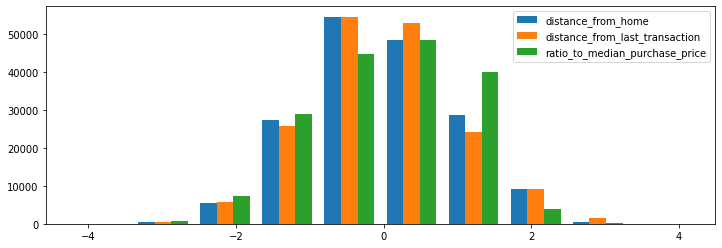

In [10]:
fig, ax = plt.subplots(1, 1, figsize=[12, 4])
plt.hist(df_b[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])
plt.legend(['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'])

Then we use a heatmap to visualize the correlations among the features. It seems that 'ratio_to_median_purchase_price' and 'online_order' are two features that are strongly correlated with 'fraud'.

<AxesSubplot:>

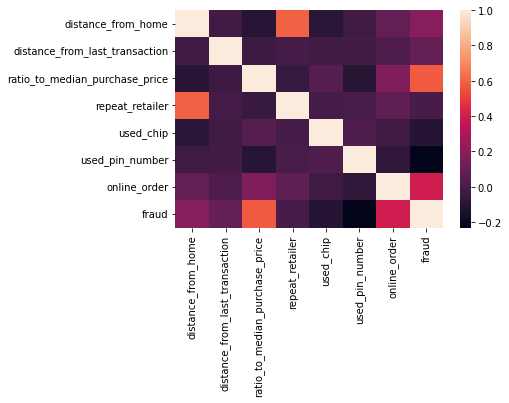

In [19]:
correlations = df_b.corr()
sns.heatmap(correlations)

Now we find the numeric predictors have been normalized.

Finally we use sklearn to divide the dataset into train and valication set.

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
predictors, targets  = list(df_b.columns[df_b.columns != 'fraud']), ['fraud']

In [54]:
df_train, df_val = train_test_split(df_b, test_size=0.2, random_state=123)
X_train, y_train = df_train[predictors].to_numpy(), df_train['fraud'].to_numpy()
X_val, y_val = df_val[predictors].to_numpy(), df_val['fraud'].to_numpy()
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((139844, 7), (34962, 7), (139844,), (34962,))

## Experimenting with different models

In this section we expore the performances of several classification models

### Logistic regression

In [68]:
def add_const(X):
    X_w_constant = np.concatenate([np.full([X.shape[0], 1], 1), X], axis=1)
    return X_w_constant
X_train_w_constant = add_const(X_train)
log_reg = sm.Logit(y_train, X_train_w_constant).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.304649
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               139844
Model:                          Logit   Df Residuals:                   139836
Method:                           MLE   Df Model:                            7
Date:                Tue, 21 Jun 2022   Pseudo R-squ.:                  0.5605
Time:                        07:00:51   Log-Likelihood:                -42603.
converged:                       True   LL-Null:                       -96932.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0399      0.034     -1.163      0.245      -0.107       0.027
x1             1.5706      0.013    120.452      0.000       1.545       1.596
x2             0.5373      0.009     61.053      0.000       0.520       0.555
x3             2.4877      0.014    174.073      0.000       2.460       2.516
x4            -2.9121      0.036    -81.019      0.000      -2.983      -2.842
x5            -1.0446      0.020    -52.858      0.000      -1.083      -1.006
x6            -5.2248      0.091    -57.109      0.000      -5.404      -5.046
x7             3.4995      0.029    119.096      0.000       3.442       3.557
==============================================================================
"""

In [74]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

In [88]:
y_probs = log_reg.predict(add_const(X_val))
y_pred = np.zeros_like(y_probs)
y_pred[y_probs>0.5] = 1


In [89]:
def evaluation(y_val, y_pred):
        print('accuracy: {}'.format(accuracy_score(y_val, y_pred)))
        print('confusion matrix:\n {}'.format(confusion_matrix(y_val, y_pred, normalize='true')))
        pre, recall, f, support = precision_recall_fscore_support(y_val, y_pred)
        print('precision: {}'.format(pre))
        print('recall: {}'.format(recall))
        print('F score: {}'.format(f))
        print('support: {}'.format(support))

In [90]:
evaluation(y_val, y_pred)

accuracy: 0.8703735484240032
confusion matrix:
 [[0.85118306 0.14881694]
 [0.11002544 0.88997456]]
precision: [0.88766234 0.85412274]
recall: [0.85118306 0.88997456]
F score: [0.86904005 0.87168016]
support: [17666 17296]


## LDA and QDA

In [83]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [81]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_val)
evaluation(y_val, y_pred)

accuracy: 0.8661403809850695
confusion matrix:
 [[0.81648364 0.18351636]
 [0.08314061 0.91685939]]
precision: [0.90934308 0.83026178]
recall: [0.81648364 0.91685939]
F score: [0.86041518 0.87141444]
support: [17666 17296]


In [84]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_val)
evaluation(y_val, y_pred)

accuracy: 0.8049596704993993
confusion matrix:
 [[0.66738367 0.33261633]
 [0.05452128 0.94547872]]
precision: [0.92594047 0.73566062]
recall: [0.66738367 0.94547872]
F score: [0.77568341 0.82747628]
support: [17666 17296]


### Decision tree

In [46]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [85]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_val)

In [86]:
evaluation(y_val, y_pred)

accuracy: 0.9999713975173045
confusion matrix:
 [[1.00000000e+00 0.00000000e+00]
 [5.78168363e-05 9.99942183e-01]]
precision: [0.9999434 1.       ]
recall: [1.         0.99994218]
F score: [0.9999717  0.99997109]
support: [17666 17296]


Visualizing the nodes of the tree:

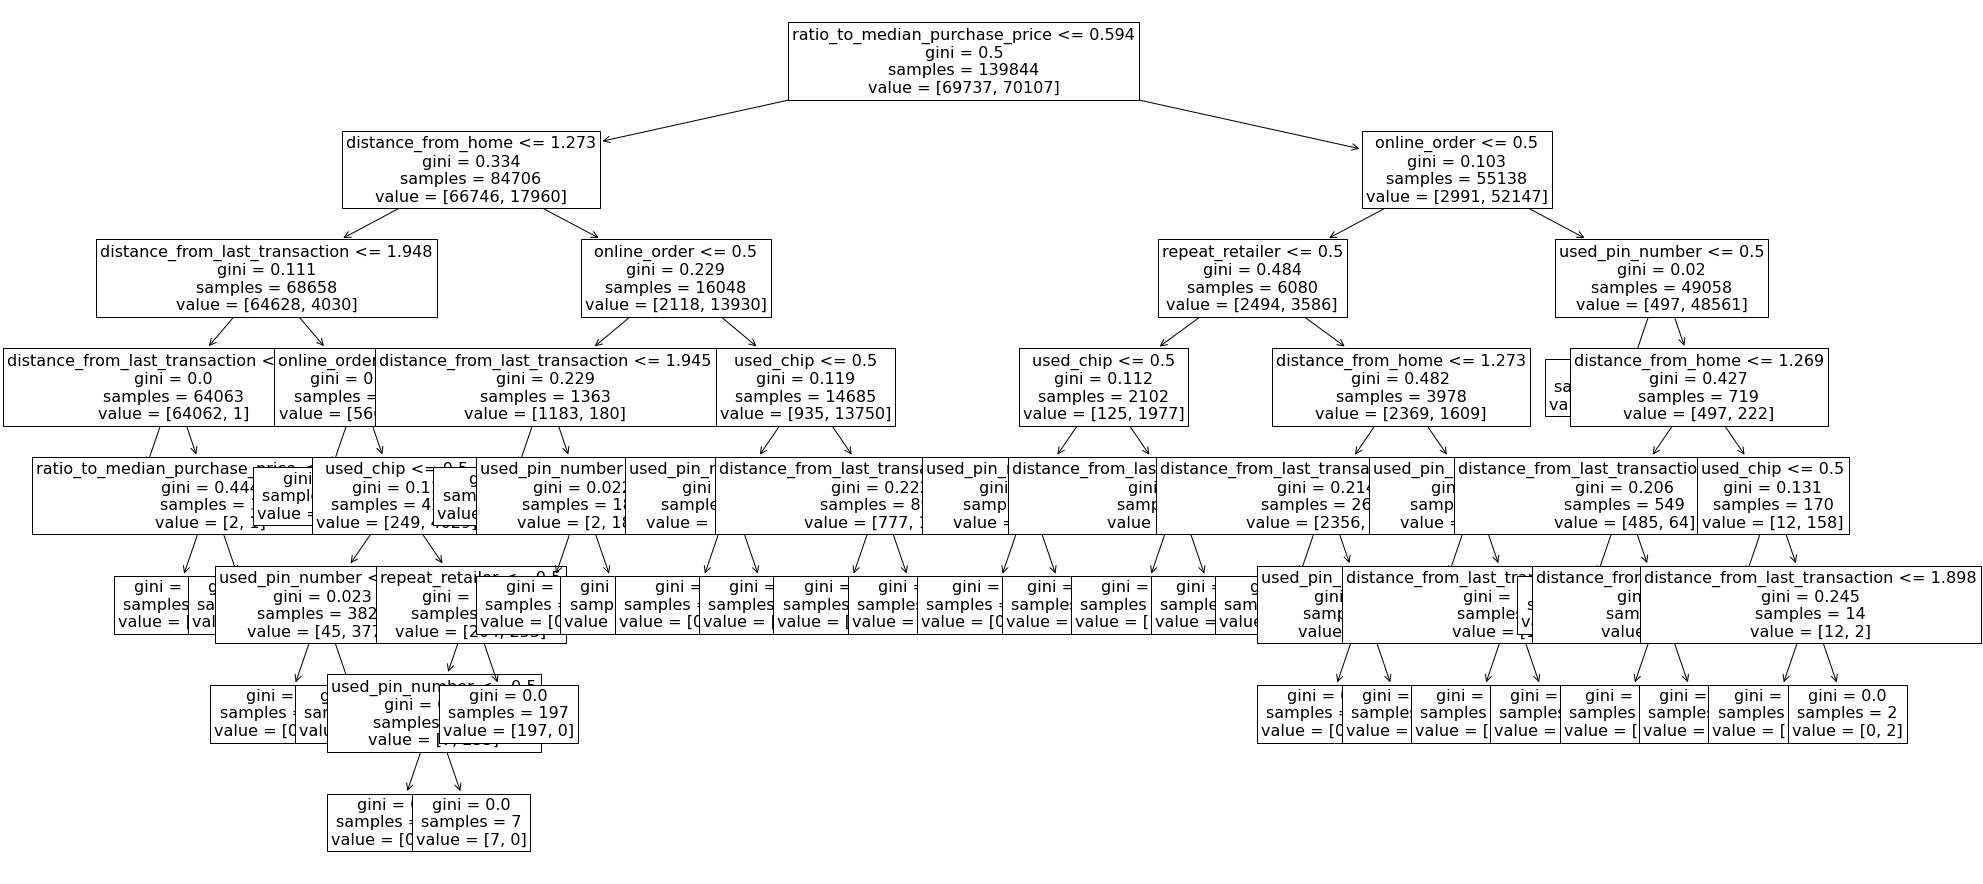

In [87]:
fig=plt.figure(figsize=[32, 16])
plot_tree(tree,  feature_names=predictors, fontsize=16)
plt.show()

## Result and discussion
Here is a summary of the metrics of the above models:

|model|accuracy|precision|recall|F score|
|---|---|---|---|---|
|logistic regression|0.870|0.854|0.890|0.872|
|LDA|0.866|0.830|0.917|0.871|
|QDA|0.805|0.735|0.945|0.871|
|decision tree|0.99997|1|0.99994218|0.99997|



Clealy, decision tree is the winner here. From the visualization of the tree we can see the tree uses 'ratio_to_median_purchase_price', 'distance_from_home' and 'online_order' as the top three predictors, which is what we expected from the heatmap of the correlation matrix. The tree examines each predictor one by one and flag the data that is suspicious. It is very close to how human beings flag fraud in real world. 